# Imports

In [1]:
import matplotlib
from pandas import read_excel 
from pandas import read_csv
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec
%matplotlib inline
from itertools import cycle
import itertools
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import os
from itertools import groupby

# Data import and mapping

This comes in handy when importing many datasets. Assigning file1 and file2 isn't strictly necessary, as you can call the files with either an indexer or list comprehensions. I do it this way so I don't have to change the code too much when switching between single file data analysis to multiple files. 

Because I am not using multiple files, you can disregard this cell.

In [3]:
x = []

for item in glob.glob("/Users/jessicagallawa/Library/CloudStorage/OneDrive-Colostate/Presodiation/XPS data/CSVs/*.csv"):
    x.extend([
        item
    ])
x.sort()
x=[x]
for num,param in enumerate(x):
    file1=param[0]
    file2=param[1]
print(file1)

/Users/jessicagallawa/Library/CloudStorage/OneDrive-Colostate/Presodiation/XPS data/CSVs/E5-15minPS_Nocycle_Pro.csv


In [7]:
file1="Sample_PRO_Sb_NativeOxide.txt"

### Define Skip-to function

This is defining a function, I use this a lot in my other code. After you run this cell, you can use this to search a CSV for a phrase/character/str that marks the start of a dataset. 

In [8]:
def skip_to(fle, line, **kwargs):
### fle = input file name, line =  str that signifies start of dataset ###
    if os.stat(fle).st_size == 0:
        raise ValueError("File is empty") 
    with open(fle) as f:
        pos = 0
        cur_line = f.readline()
        while not cur_line.startswith(line):
            pos = f.tell()
            cur_line = f.readline()
        f.seek(pos)
        return pd.read_csv(f, **kwargs)

In [9]:
def get_index(list_of_strings, substring):
    try:
        return next(i for i, e in enumerate(list_of_strings) if substring in e)
    except StopIteration:
        return len(list_of_strings) - 1

This next cell makes a big dataframe with grouped data based on environment and sputter time. I use multi-indexing (pandas) to accomplish this. In the cell to the right of "B.E." (the independent variable of each dataset) the header has the following: "Cycle #:"filename":"env":CPS". We want the number and env from this cell, as these will constitute the index variables for grouping. Errors can arise here if there are variations in how you exported the data. If that is the case, the culprit is likely that cell next to "B.E.".

An old version of this code used empty columns as flags instead of B.E. labels. If, for whatever reason, you have B.E. anywhere that is not in the B.E. column, you could run into errors, and I would switch to using the old version (v1.1).

I found that the export from CasaXPS duplicates some of the data. I added a line of code that finds the first instance of a duplicate label (the second header in each table) by finding "CPS.1". For pd.read_csv, duplicate header values are appended with a .#. After the index is found, all of the columns after that are removed. 

In [14]:
# Import mega df starting at data row and skipping empty columns

XPS = skip_to(file1,"B.E.", sep="	",skiprows=0,skip_blank_lines=False).dropna(axis=1, how='all')


Header = list(XPS)

# Remove duplicate datasets

reps=get_index(Header,"CPS.1")
rep_range=len(Header)-(reps-1)
XPS = XPS.iloc[:,:-rep_range]

Header = list(XPS)

# Find the Binding Energy Columns

BE_Cols  = [col for col in XPS.columns if 'B.E.' in col]

# Use BE cols to find BE indeces and Label indeces

BE_Indices = []
Label_Indices = []

for i in BE_Cols:
    x = XPS.columns.get_loc(i) #BE index
    BE_Indices.append(x)
    Label_Indices.append(x+1)
    
# Make a list of the index upper limits in each dataset :
# lower limit is BE
# upper limit is the next BE

tails = BE_Indices.copy()
tails.append(len(XPS.columns)) #get the upper limit of the last dataset
del tails[0] #remove the first index value

#Labels are the second column name in each dataset and store the etch time and the environment

Labels = []

for i in Label_Indices:
    x = XPS.columns[i]
    Labels.append(x)

# Retrieve etch time and env from Labels

times = []
envs = []

for i in Labels:
    split_list=i.split(':')
    time=split_list[0].split(' ')[1]
    times.append(time)
    env_list = split_list[3].split(' ')
    env_name = ' '.join([env_list[0],env_list[1]])
    envs.append(env_name)
map(str, times)
time_index = []
env_index = []
zipped = zip(BE_Indices,tails,envs,times)

for num,param in enumerate(zipped):
    BE=param[0]
    Tail=param[1]
    Env=param[2]
    Time=param[3]
    
    for i in range(Tail-BE):
        time_index.append(Time)
        env_index.append(Env)

XPS.columns = pd.MultiIndex.from_arrays([env_index,time_index,Header])


# If you use multiple files, you can make a copy of the XPS df then just duplicate this cell
# That way you don't have to copy cells 
#XPS_1=XPS.copy()


#Retrieving data
print(XPS["Sb 3d"]["300"]) #Sb environment, after 300s sputtering

     B.E..19  Cycle 300:09092210.pro:Sample_Pro_Sb_NativeOxide:Sb 3d 20:CPS  \
0      545.0                                             4810.0               
1      544.9                                             4740.0               
2      544.8                                             4490.0               
3      544.7                                             4730.0               
4      544.6                                             4550.0               
..       ...                                                ...               
495      NaN                                                NaN               
496      NaN                                                NaN               
497      NaN                                                NaN               
498      NaN                                                NaN               
499      NaN                                                NaN               

     Sb 3d 20:Sb 3d  Sb 3d 20:Sb 3d.1  Sb 3d 20:Sb 

# Plotting

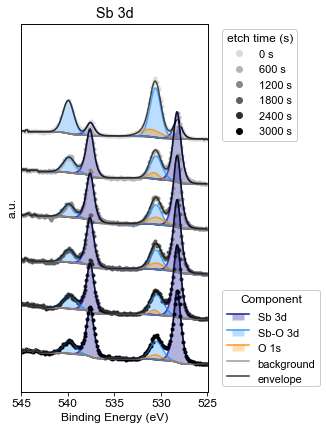

In [73]:
# Single plot with Envelope + fits


env = 'Sb 3d' #change to whatever element is labeling the binding environment 
cmap = matplotlib.colormaps['Greys']

# Because we're plotting components, we need to specify colors and labels
comp1="Sb 3d" #component id
C1="darkblue" #component color
comp2="Sb-O 3d"
C2="dodgerblue"
comp3="O 1s"
C3="darkorange"

plots=[comp1,comp1,comp2,comp2,comp3,"background","envelope"] # labels
comps=range(2,(len(plots)+2)) # corresponding df column within level
colors=[C1,C1,C2,C2,C3,"grey","black"] # Splitting of P/D/F orbitals results in two peaks for the same comp
# if you don't merge the lineshapes in casa, just make sure the colors are the same (as shown here)

# plot style parameters


    # Params
matplotlib.rcParams['figure.figsize'] = 4.5, 7
matplotlib.rcParams['font.family'] = 'arial'
matplotlib.rcParams['font.size']=12

################################################################################

fig = plt.figure()
ax = fig.add_subplot(111)

# plot data parameters 
offset = 0.6 # percent – 0.3 means the offset is 30% of the Y-range,
             # 1 means 
etimes=[-10,600,1200,1800,2400,3000] # etch times you want to plot 
ax.set_xlim(545,525) #x-axis limits, for XPS plot w/decreasing BE on X axis

################################################################################

# finding min and max y value from selected etimes
# so you can iteratively plot offsets percent-wise instead of guess+check
# Finds the largest range across all the data points plotted (lowest and highest values) and uses that to normalize an offset
n=len(etimes)
ymax=[]
ymin=[]
for i in etimes:
    ymax.append(max(XPS[env][str(i)].max(numeric_only=True)))
    ymin.append(min(XPS[env][str(i)].min(numeric_only=True)))
Yrange=max(ymax)-min(ymin)

################################################################################

# Plotting - iteratively

for i in etimes:
    data=XPS[env][str(i)]
    
    x = data.iloc[:,0]
    y = data.iloc[:,1]+(n*Yrange*offset)
    bg=data.iloc[:,-2]+(n*Yrange*offset)
    
    #Casa exports the t=0 plots as negative values, so let's just switch the label
   
    if i == -10:
        plt.plot(x,y,'.',label='0 s',markersize=6,lw=0,color=cmap((i+1000)/(max(etimes)+1000)))
    else:
        plt.plot(x,y,'.',label= str(i) + ' s',markersize=6,lw=0,color=cmap((i+1000)/(max(etimes)+1000)))
        
    # Iteratively plot components
    for num,param in enumerate(zip(plots,colors,comps)): 
        
        label=param[0] # component
        col=param[1] # color
        com=param[2] # column
        y = data.iloc[:,com]+(n*Yrange*offset) 
        plt.plot(x,y,color=col,alpha=0.7)
        if com < len(plots): #don't want to fill the envelope (change if you want that though)
            plt.fill_between(x,y,bg,color=col,alpha=0.3)

    n = n-1  # for offset automation: if you want t=0 at the bottom, then change this to be n=n+1 and 
             # change line 44 to be n=0 instead of n=len(etimes)

plt.subplots_adjust(right=0.7,bottom=0.15)

################################################################################

# Adding a legend when multiple lines per component

ax2 = ax.twinx() # this will be a blank axis, so we can have a second legend
plots_u=[i for n, i in enumerate(plots) if i not in plots[:n]] #remove duplicate components
colors_u=[i for n, i in enumerate(colors) if i not in colors[:n]] #remove duplicate colors
alphas=[0.3,0.3,0.3,0,0] # alpha for fill - 0 for no fill under bg and envelope
legs=[] # use this to add custom legend handles made of tuples 

# Making 'ghost' components for the legend
for num,param in enumerate(zip(plots_u,colors_u,alphas)):
    com=param[0]
    col=param[1]
    a=param[2]
    lin,=ax2.plot(np.nan,np.nan,color=col,alpha=0.8)
    fil,=ax2.plot(np.nan,np.nan,marker="s",fillstyle='bottom',color=col,alpha=a,markersize=12,markeredgecolor='none')
    legs.append((lin,fil)) #appending the component handle as a touple
    

#etch time legend
leg=ax.legend(bbox_to_anchor=(1.05,1),fontsize=11,fancybox=True, frameon=True,framealpha=1,loc="upper left",title='etch time (s)',markerscale=2)
leg_2=ax2.legend(legs,plots_u,bbox_to_anchor=(1.05,0), fontsize=11,fancybox=True, frameon=True,framealpha=1,loc="lower left",title='Component')


for t in leg_2.get_texts():
    t.set_va('center') # va is alias for verticalalignment
    #t.set_position((shift,0))
ax2.set_yticks([])

#ax.legend(bbox_to_anchor=(1.05,1), fontsize=11,fancybox=True, frameon=True,framealpha=1,loc="upper left",title='etch time (s)')
ax.set_ylim(min(ymin)+(Yrange*offset*0.4),max(ymax)+(Yrange*len(etimes)*offset*1.15))
ax.set_xlabel('Binding Energy (eV)')
ax.set_ylabel('a.u.')
ax.set_yticks([])
plt.title(env)

plt.savefig("example_sputter_profile_w-fits"+str(env)+".pdf",dpi=300)

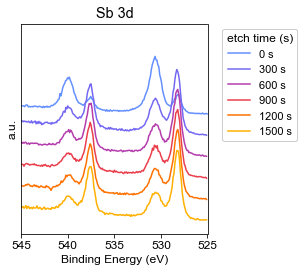

In [17]:
# Single plot with Envelope


env = 'Sb 3d' #change to whatever element is labeling the binding environment 

# plot style parameters

    # colors
colormp = ['#648FFF','#785EF0','#DC267F','#FE6100','#FFB000']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colormp)

    # Params
matplotlib.rcParams['figure.figsize'] = 4.5, 4
matplotlib.rcParams['font.family'] = 'arial'
matplotlib.rcParams['font.size']=12

################################################################################

fig = plt.figure()
ax = fig.add_subplot(111)

# plot data parameters 
offset = 0.3 # percent – 0.3 means the offset is 30% of the Y-range,
             # 1 means 
etimes=[-10,300,600,900,1200,1500] # etch times you want to plot 
ax.set_xlim(545,525) #x-axis limits, for XPS plot w/decreasing BE on X axis

################################################################################

# finding min and max y value from selected etimes
# so you can iteratively plot offsets percent-wise instead of guess+check
n=len(etimes)
ymax=[]
ymin=[]
for i in etimes:
    ymax.append(max(XPS[env][str(i)].max(numeric_only=True)))
    ymin.append(min(XPS[env][str(i)].min(numeric_only=True)))
Yrange=max(ymax)-min(ymin)

################################################################################

# Plotting - iteratively

for i in etimes:
    data=XPS[env][str(i)]
    
    x = data.iloc[:,0]
    y = data.iloc[:,1]+(n*Yrange*offset)

    n = n-1
    if i == -10:
        plt.plot(x,y,label='0 s',color=cmap(i/max(etimes)))
    else:
        plt.plot(x,y,label= str(i) + ' s',color=cmap(i/max(etimes)))
plt.subplots_adjust(right=0.7,bottom=0.15)

ax.legend(bbox_to_anchor=(1.05,1), fontsize=11,fancybox=True, frameon=True,framealpha=1,loc="upper left",title='etch time (s)')

ax.set_ylim(min(ymin)+(Yrange*offset*0.4),max(ymax)+(Yrange*len(etimes)*offset*1.15))
ax.set_xlabel('Binding Energy (eV)')
ax.set_ylabel('a.u.')
ax.set_yticks([])
plt.title(env)

plt.savefig("example_sputter_profile_"+str(env)+".pdf",dpi=300)

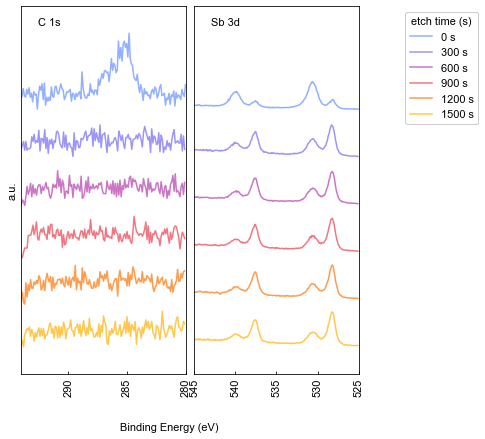

In [22]:
# Multiple environments, raw
title = 'Sb Native Oxide – Sample Profile'

labels=['C 1s','Sb 3d']
# If you want just the element, pass labels=envs

env_llims = [294,545] #lower limits for each env BE
env_ulims = [280,525] #upper limits for each env BE

#plot style parameters
colormp = ['#648FFF','#785EF0','#DC267F','#FE6100','#FFB000']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colormp)

matplotlib.rcParams['figure.figsize'] = 7.5, 7 #(I don't use this)
matplotlib.rcParams['font.family'] = 'arial'
matplotlib.rcParams['font.size']=11
fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) #rows, columns, [ht ratios] 
gs.update(wspace=0.05) 

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

axs = [ax1,ax2]


ax1.set_ylabel('a.u.')
fig.text(0.4, 0.04, 'Binding Energy (eV)', ha='center')

#plot data parameters 
offset = 1.5

etimes=[-1,120,240,360,480,600] #Etch Times - should match data


####################################
# This is to automate the offsets for each plot
# so you can still maniplulate the offset and y limits percentage-wise
# without having to do weird calculations/guess+check
ys=[]
yll=[]
yul=[]
yr=[]

for env in ['C 1s','Sb 3d']:
    y=[]
    for i in ['-10','300','600','900','1200','1500']:
        y.append(XPS[env][i].iloc[: ,1].dropna().to_list())
    yll.append(min(y[1]))
    yul.append(max(y[1]))
    yr.append(max(y[1])-min(y[1]))

    
##################################

for num,param in enumerate(zip(labels,axs,env_llims,env_ulims,yll,yul,yr)):
    #defining repeating variables
    env=param[0]
    ax=param[1]
    llim=param[2]
    ulim=param[3]
    label=param[0]
    
    y_ll=param[4]
    y_ul=param[5]
    y_r=param[6]
    
    etimes=[-10,300,600,900,1200,1500] 
    n=len(etimes) #counter for offsets
    
    #ax visual parameters
    ax.set_yticks([])
    ax.tick_params(axis='x',direction='in',labelrotation=90)
    ax.annotate(label,[0.1,0.95],xycoords='axes fraction')
    ax.set_xlim(llim,ulim)
    ax.set_ylim(y_ll+(y_r*offset*0.4),y_ul+(y_r*n*offset*1.25))
    
    # finding min and max y value from selected etimes
    # so you can iteratively plot offsets percent-wise instead of guess+check

    ymax=[]
    ymin=[]
    
    for i in etimes:
        a = str(i)
        data=XPS[env][a]
    
        x = data.iloc[:,0]
        y = data.iloc[:,1] + (n*y_r*offset) 
        #the offset is 
        
        n = n-1
        
        if i == -10: #it exports where t=0 is -1, just convert
            ax.plot(x,y,label='0 s',color=cmap(i/max(etimes)),alpha=0.7)
        else:
            ax.plot(x,y,label= a + ' s',color=cmap(i/max(etimes)),alpha=0.7)

plt.subplots_adjust(right=0.75,bottom=0.15)

ax2.legend(bbox_to_anchor=(1.25,1), fontsize=11,fancybox=True, frameon=True,framealpha=1,loc="upper left",title='etch time (s)')
plt.savefig(title+" Profile",dpi=300)
